# Albin Åberg Dahlberg
Exploration

## Notebook for plotting MixIRLS on reference files of ToF-ERDA experiments

In [1]:
import sys
import os
import glob

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt

from utils.data import load_tof, Phi
from utils.plot import make_palette
from image_processing_filter import process

from models.mixture import MixIRLS

Load data, filter noise and feature engineer 

In [2]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst'
X_raw, y_raw = load_tof(FILE_PATH, unique=True)
X, y = process(X_raw, y_raw, strength=0.15)
exponents = [-1/2, -1]
phi = Phi(X, exponents)

Plot feature space

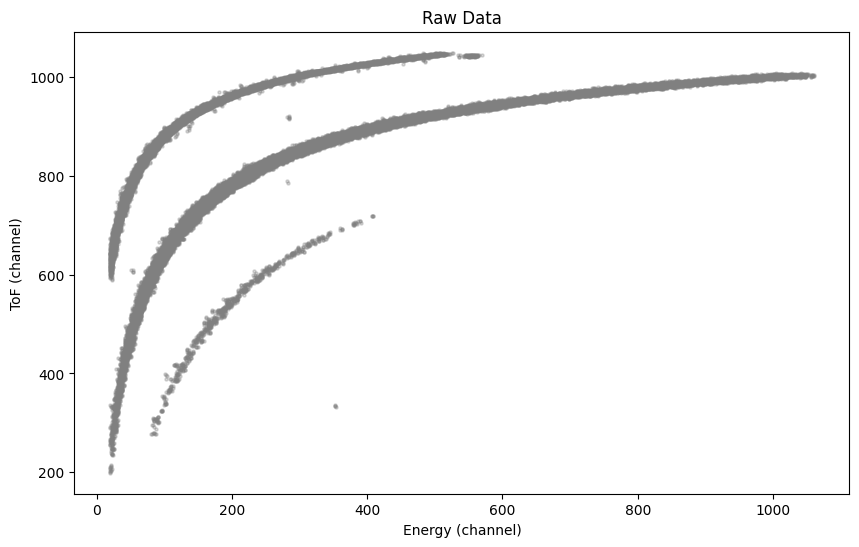

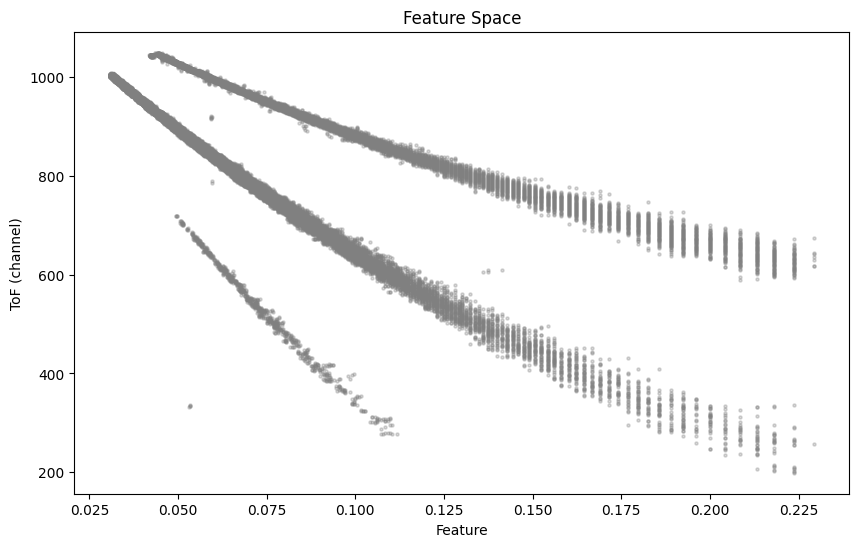

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.3, color='grey', s=5)
plt.ylabel('ToF (channel)')
plt.xlabel('Energy (channel)')
plt.title('Raw Data')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(phi[:,0], y, alpha=0.3, color='grey', s=5)
plt.ylabel('ToF (channel)')
plt.xlabel('Feature')
plt.title('Feature Space')
plt.show()

Train model

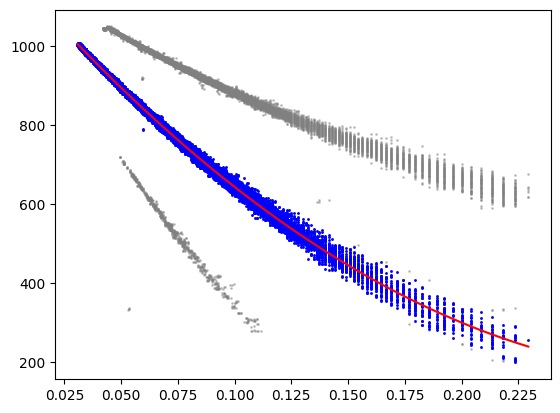

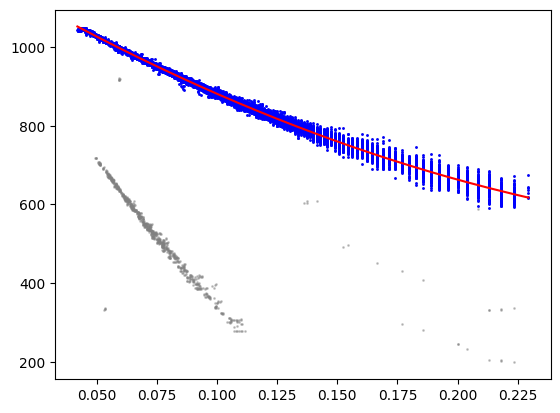

Parameters for 2 components:
 [[ 1197.59051723  1195.43800936]
 [-6602.84444363 -3629.79070838]
 [10572.43245985  4840.5359735 ]]


In [4]:
K = 2
w_th=0.9
plot = True

model = MixIRLS(K=K, w_th=w_th, plot=plot)

sprim, supports, iter = model.train(phi, y)
print(f"Parameters for {K} components:\n", model.beta)

Plot results

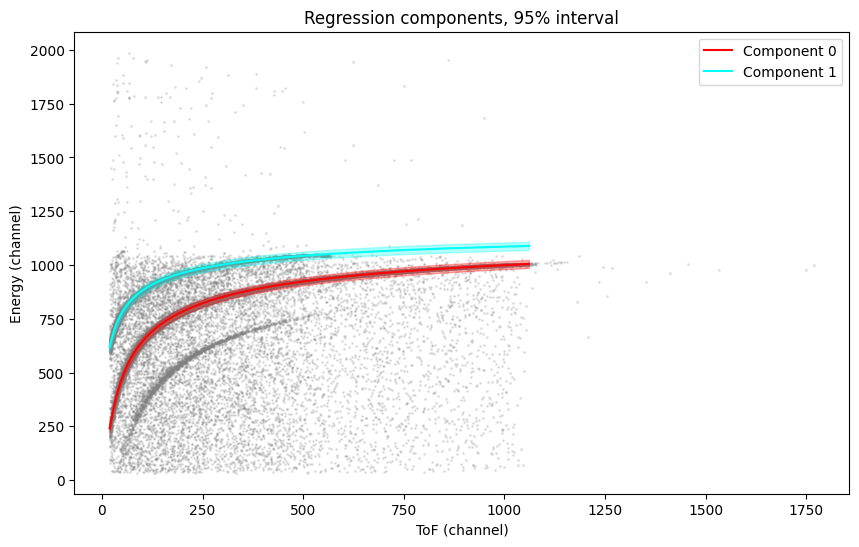

In [5]:
colors = make_palette(K, cmap=plt.cm.hsv)

plt.figure(figsize=(10, 6))
plt.scatter(X_raw, y_raw, alpha=0.2, color='grey', s=1)
plt.xlabel('ToF (channel)')
plt.ylabel('Energy (channel)')
plt.title('Regression components, 95% interval')

# Predict all components at once
y_pred = model.predict(phi)
for k in range(K):
    plt.plot(X, y_pred[:,k], color=colors[k], label=f"Component {k}")
    plt.fill_between(X, y_pred[:,k] - 2*np.sqrt(model.sigma[k]), y_pred[:,k] + 2*np.sqrt(model.sigma[k]), color=colors[k], alpha=0.3)
    
plt.legend()
plt.show()

Points in support for component 0:  24534
  Number of points in component 0:  16966

Points in support for component 1:  7568
  Number of points in component 1:  6755



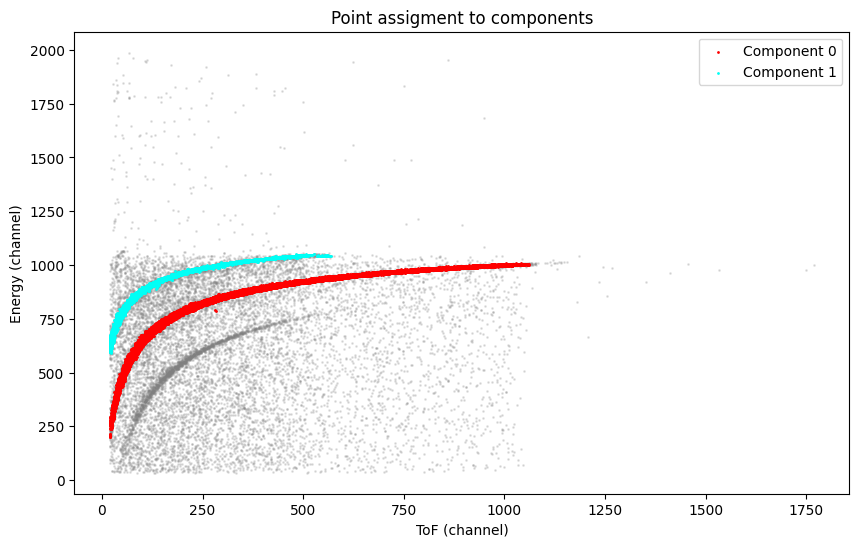

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(X_raw, y_raw, alpha=0.2, s=1, color='grey')
plt.xlabel('ToF (channel)')
plt.ylabel('Energy (channel)')
plt.title('Point assigment to components')
for k in range(K):
    
    i, j = model.get_component_indeces(k)
    E, ToF = model.get_component_points(X, y, k)

    print(f"Points in support for component {k}: ", i.sum())
    print(f"  Number of points in component {k}: ", len(X[i][j]), end='\n\n')
    
    plt.scatter(E, ToF, alpha=1, s=1, marker='o',  color=colors[k], label=f"Component {k}")

plt.legend()
plt.show()

          E   ToF  pred                                color
0        19   257     0                 [1.0, 0.0, 0.0, 1.0]
1        19   617     1  [0.0, 1.0, 0.9647031631761764, 1.0]
2        19   618     1  [0.0, 1.0, 0.9647031631761764, 1.0]
3        19   630     1  [0.0, 1.0, 0.9647031631761764, 1.0]
4        19   636     1  [0.0, 1.0, 0.9647031631761764, 1.0]
...     ...   ...   ...                                  ...
36151  1412   961    -1                                 grey
36152  1456  1004     0                 [1.0, 0.0, 0.0, 1.0]
36153  1534   976    -1                                 grey
36154  1749   978    -1                                 grey
36155  1770   998    -1                                 grey

[36156 rows x 4 columns]


C:\Users\albin\AppData\Local\Temp\ipykernel_17360\3449379113.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


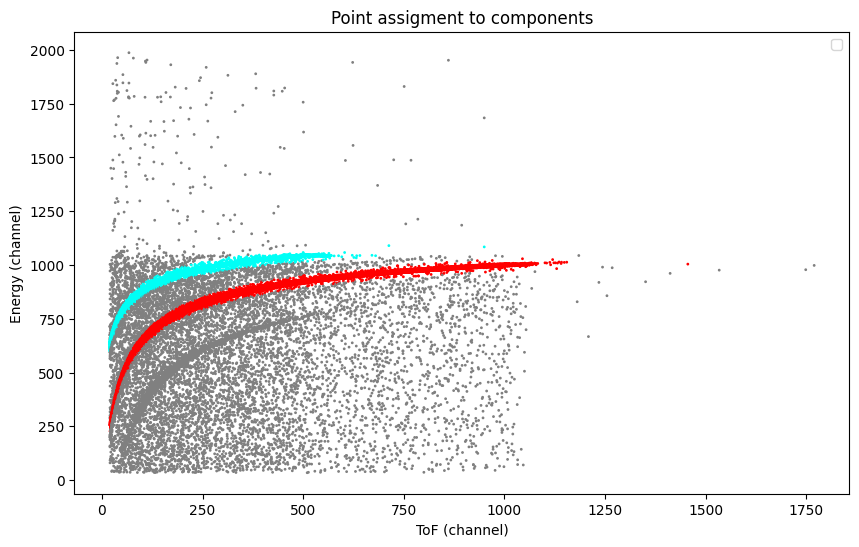

In [7]:
import pandas as pd

color_map = {
    -1: 'grey',
    0: colors[0],
    1: colors[1],
    2: colors[2]
}

plt.figure(figsize=(10, 6))
plt.xlabel('ToF (channel)')
plt.ylabel('Energy (channel)')
plt.title('Point assigment to components')

phi_raw = Phi(X_raw, exponents)
raw = np.unique(np.vstack([X_raw, y_raw]).T, axis=0)
data = pd.DataFrame(raw, columns=['E', 'ToF'])

data['pred'] = model.assign_cluster(phi_raw, y_raw)
data['color'] = data['pred'].map(color_map)
print(data)
plt.scatter(data['E'], data['ToF'], c=data['color'], alpha=1, s=1, marker='o')    

plt.legend()
plt.show()